# Branded food data frame analysis

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [4]:
filepath = lambda x: os.path.join('data', x)

In [5]:
branded_food = pd.read_csv(filepath('branded_food.csv'), dtype={
    'brand_owner':str,
    'brand_name':str,
    'subbrand_name':str,
    'gtin_upc':str})
branded_food.head()

C:\Users\Alexander\AppData\Local\Temp\ipykernel_14692\1118146348.py:1: DtypeWarning: Columns (6,9,12,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  branded_food = pd.read_csv(filepath('branded_food.csv'), dtype={


,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,00027000612323,Vegetable Oil,NaN,15.0,ml,NaN,Oils Edible,GDSN,NaN,2020-10-02,2020-11-13,United States,NaN,NaN,NaN,NaN
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,00051000198808,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",NaN,240.0,ml,NaN,Herbs/Spices/Extracts,GDSN,NaN,2020-09-12,2020-11-13,United States,NaN,NaN,NaN,NaN
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,00051000213273,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",NaN,440.0,g,NaN,Prepared Soups,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,00051000213303,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",NaN,440.0,g,NaN,Prepared Soups,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,00051000224637,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",NaN,240.0,ml,NaN,Herbs/Spices/Extracts,GDSN,NaN,2020-10-03,2020-11-13,United States,NaN,NaN,NaN,NaN


Going through the initial inspection of the dataset:

- Missingness/null values
- incorrect dtypes
- Reducing of columns/memory if possible]
- Validation of data (outlier searching and correction of incorrect values)

## Initial Missingness check

In [6]:
branded_food.isnull().mean()

fdc_id                         0.000000
brand_owner                    0.007813
brand_name                     0.296762
subbrand_name                  0.952827
gtin_upc                       0.000000
ingredients                    0.002923
not_a_significant_source_of    0.960171
serving_size                   0.005842
serving_size_unit              0.010312
household_serving_fulltext     0.585086
branded_food_category          0.005729
data_source                    0.000000
package_weight                 0.617388
modified_date                  0.000011
available_date                 0.000000
market_country                 0.000000
discontinued_date              1.000000
preparation_state_code         0.978783
trade_channel                  0.991557
short_description              0.978720
dtype: float64

We see that there are some columns with missing data, mainly towards the end, including discontinued_date, preparation_state_code, trade_channel, and short_description, which we will take a look through non-null examples and drop if necessary to preserve memory.

In [7]:
has_prep_code = branded_food[branded_food.preparation_state_code.notnull()]
has_prep_code.head()

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1549669,2219410,Cargill Incorporated/Honeysuckle White,HONEYSUCKLE WHITE,NaN,00642205546077,"Turkey, Natural Flavoring",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1 LBR,2019-03-07,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh 93% Grd Tky Chub 12/1
1549670,2219411,Cargill Incorporated/Honeysuckle White,Honeysuckle White,NaN,00642205534517,"All Natural White Turkey, Natural Flavoring",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1.25 LBR,2020-02-04,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh Gr WhtDry Ex Wt 6/1.25#
1549671,2219412,Cargill Incorporated/Honeysuckle White,HONEYSUCKLE WHITE,NaN,00642205534500,"All Natural Turkey, Natural Flavoing",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1.25 LBR,2020-02-05,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh 85/15 Gr tky Ex Wt 6/1.25
1549672,2219413,Kellogg Company US,Kellogg's Pop-Tarts,NaN,00038000317101,"Enriched flour (wheat flour, niacin, reduced i...",NaN,52.0,g,1 Pastry,Sweet Bakery Products,GDSN,14.7 ONZ,2019-04-09,2022-02-10,United States,NaN,UNPREPARED,NaN,Pop-Tarts
1549673,2219414,Kellogg Company US,Kellogg's Cheez It,NaN,00024100105236,"Enriched flour (wheat flour, niacin, reduced i...",NaN,25.0,g,1 Pouch,Biscuits/Cookies,GDSN,12.6 ONZ,2019-04-30,2022-02-10,United States,NaN,UNPREPARED,NaN,Gripz Crackers


In [8]:
has_prep_code.preparation_state_code.value_counts()

UNPREPARED        26631
PREPARED           5676
READY_TO_EAT       2830
READY_TO_DRINK     2677
BAKE                603
HEAT_AND_SERVE      272
THAW                147
FREEZE               97
GRILL                95
CONVECTION           36
UNSPECIFIED          22
FRY                  15
STEAM                12
DEEP_FRY             12
ROAST                11
BOIL                  7
MICROWAVE             4
STIR_FRY              4
Name: preparation_state_code, dtype: int64

We see that many of these are with respect to how to prepare the food for consumption, many of which are simply labeled "unprepared" or prepared. We also see that many of these preparation codes are disambiguous, as unprepared does contain also foods that would be considered ready to eat, such as Pop-Tarts or Cheez-its. Because of this, it may be hard to categorize food into explicitly "prepared" and "unprepared" categories.

In [9]:
has_prep_code[has_prep_code.preparation_state_code == 'UNPREPARED'].head(5)

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1549669,2219410,Cargill Incorporated/Honeysuckle White,HONEYSUCKLE WHITE,NaN,00642205546077,"Turkey, Natural Flavoring",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1 LBR,2019-03-07,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh 93% Grd Tky Chub 12/1
1549670,2219411,Cargill Incorporated/Honeysuckle White,Honeysuckle White,NaN,00642205534517,"All Natural White Turkey, Natural Flavoring",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1.25 LBR,2020-02-04,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh Gr WhtDry Ex Wt 6/1.25#
1549671,2219412,Cargill Incorporated/Honeysuckle White,HONEYSUCKLE WHITE,NaN,00642205534500,"All Natural Turkey, Natural Flavoing",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1.25 LBR,2020-02-05,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh 85/15 Gr tky Ex Wt 6/1.25
1549672,2219413,Kellogg Company US,Kellogg's Pop-Tarts,NaN,00038000317101,"Enriched flour (wheat flour, niacin, reduced i...",NaN,52.0,g,1 Pastry,Sweet Bakery Products,GDSN,14.7 ONZ,2019-04-09,2022-02-10,United States,NaN,UNPREPARED,NaN,Pop-Tarts
1549673,2219414,Kellogg Company US,Kellogg's Cheez It,NaN,00024100105236,"Enriched flour (wheat flour, niacin, reduced i...",NaN,25.0,g,1 Pouch,Biscuits/Cookies,GDSN,12.6 ONZ,2019-04-30,2022-02-10,United States,NaN,UNPREPARED,NaN,Gripz Crackers


## Serving size cleaning

In [10]:
branded_food.serving_size_unit.value_counts()

g      1522350
ml      243399
GRM      40597
MLT       8288
MG        7555
IU        3671
GM         346
MC          63
Name: serving_size_unit, dtype: int64

We see that there are several options. We will look up what these units exactly mean (unabbreviated), and possibly merge any containing the same amount. We can also visualize the distributions of respective foods.

- g (gram)
- ml (mililiter, most likely for fluids)
- grm - unknown, will compare to gram's distribution for differences
- mlt - Unknwon
- MG - possibly a milligram distribution
- IU - 

In [11]:
grm_foods = branded_food[branded_food.serving_size_unit == 'GRM']
grm_foods

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1751470,2456687,SCHWAN'S FOOD SERVICE INC,TONY'S,NaN,10072180726718,"INGREDIENTS: FRENCH BREAD (WATER, WHITE WHOLE ...",NaN,156.0,GRM,1 Pizza (156g),Pies/Pastries/Pizzas/Quiches - Savoury (Frozen),GDSN,60 EA,2022-12-15,2023-01-26,United States,NaN,UNPREPARED,"[""CHILD_NUTRITION_FOOD_PROGRAMS""]",TN FB WG CHS 100
1751471,2456688,Bake Crafters Food Company,Bake Crafters,NaN,00737410335001,"Enriched Wheat Flour [Wheat Flour, Malted Barl...",NaN,28.0,GRM,1 oz (28g),Bread (Frozen),GDSN,6.25 LBR,2022-06-02,2023-01-26,United States,NaN,UNPREPARED,NaN,"Pullman Bread, White, 1 Slice, IW"
1751472,2456689,Bake Crafters Food Company,Bake Crafters,NaN,00737410171708,"Whole Wheat Flour, Enriched Bleached Wheat Flo...",NaN,78.0,GRM,"2.75 oz (78g), 4 pieces",Desserts (Frozen),GDSN,12.375 LBR,2022-06-02,2023-01-26,United States,NaN,UNPREPARED,"[""CHILD_NUTRITION_FOOD_PROGRAMS"",""CHILD_NUTRIT...","Mini Breakfast Bites, Glz, WG, 4 Pk"
1751473,2456690,Bake Crafters Food Company,Bake Crafters,NaN,00737410158105,"Water, Whole Wheat Flour, Enriched Wheat Flour...",NaN,40.0,GRM,"1.4 oz (40g), 2 Pancakes",Bread (Frozen),GDSN,14.175 LBR,2022-06-02,2023-01-26,United States,NaN,UNPREPARED,"[""CHILD_NUTRITION_FOOD_PROGRAMS"",""CHILD_NUTRIT...",Pancakes WG Wholesome Choice Mpl Ch
1751474,2456691,Brakebush Brothers,Brakebush,NaN,10038034558706,UNCOOKED BONELESS CHICKEN BREAST TENDERS CONTA...,NaN,71.0,GRM,1 Piece,Chicken - Prepared/Processed,GDSN,10 LBR,2022-04-26,2023-01-26,United States,NaN,UNPREPARED,NaN,Crispy-Lishus tenders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845290,2554908,Tanjoe Enterprises Inc.,LIDIA'S,NaN,897712001049,"ITALIAN TOMATOES (CITRIC ACID), ARTICHOKES, CA...",NaN,125.0,GRM,1/2 cup,Prepared Pasta & Pizza Sauces,LI,25 oz/708 g,2023-03-27,2023-05-25,United States,NaN,NaN,NaN,NaN
1845291,2554909,Oregon Growers & Shippers LLC,OREGON GROWERS,NaN,898271000948,"BLACKBERRIES (MARIONBERRIES, BLACKBERRIES), CA...","Not a significant source of saturated fat, tra...",39.0,GRM,2 Tbsp,Syrups & Molasses,LI,8 fl oz/237 mL,2023-04-26,2023-05-25,United States,NaN,NaN,NaN,NaN
1845292,2554910,Mt. Garfield Winery Corp,LIFESTYLEFOODS,NaN,898425002682,ARCADIAN HARVEST LETTUCE (BLEND OF LEAF LETTUC...,NaN,163.0,GRM,NaN,"Pickles, Olives, Peppers & Relishes",LI,5.75 oz./163 g,2023-03-10,2023-05-25,United States,NaN,NaN,NaN,NaN
1845295,2554913,"Ittella International, Inc.",TATTOOED CHEF,NaN,899764001527,"CAULIFLOWER, CORN FLOUR, GRANA PADANO CHEESE (...",NaN,71.0,GRM,1 pc,Frozen Patties and Burgers,LI,10 oz/283 g,2023-03-23,2023-05-25,United States,NaN,NaN,NaN,NaN


One thing to note is the serving size amount of grm corresponding to the household serving fulltext. We can see many examples where the gram amount corresponds to what is labeled in household serving fulltext:

In [12]:
(
    grm_foods[grm_foods.household_serving_fulltext.str.contains('g)', regex=False).fillna(False)]
    [['serving_size', 'serving_size_unit', 'household_serving_fulltext']]
)

,serving_size,serving_size_unit,household_serving_fulltext
1751470,156.0,GRM,1 Pizza (156g)
1751471,28.0,GRM,1 oz (28g)
1751472,78.0,GRM,"2.75 oz (78g), 4 pieces"
1751473,40.0,GRM,"1.4 oz (40g), 2 Pancakes"
1751477,34.0,GRM,"1.19 oz (34g), 1 Bread Stick"
...,...,...,...
1841730,4.0,GRM,2 Tbsp (4g)
1841731,79.0,GRM,"2.8 oz (79g), 1 Biscuit"
1842987,61.0,GRM,2/3 cup dry mix (61g) (1cup prepared)
1842989,61.0,GRM,1 link (g)


From this we can most likely consider **grm** as synonymous with the **g** abbreviation. 

In [13]:
g_foods = branded_food[branded_food.serving_size_unit == 'g']
g_foods[g_foods.household_serving_fulltext.str.contains('g)', regex=False).fillna(False)][['serving_size', 'serving_size_unit', 'household_serving_fulltext']]

,serving_size,serving_size_unit,household_serving_fulltext
34110,17.0,g,1 Tbsp (17g)
34285,17.0,g,1 Tbsp(17g)
34382,62.0,g,1/4 cup (62g)
34383,62.0,g,1/4 cup (62g)
34384,62.0,g,1/4 cup (62g)
...,...,...,...
1757337,54.0,g,3 sheets (3x18g) dry
1759907,85.0,g,1 cup salad only/ 1 cup dressed salad with top...
1760115,85.0,g,1 cup salad only/1 cup dressed salad with topp...
1776928,85.0,g,"1 Cup Vegetables (85 g), 4 pieces Sausage (16 ..."


If we only look at these examples, we would consider them as conventionally the same. However, they may not be the same exactly. One way we can possibly further reinforce this idea is through a permutation test; if we assume that they're from the same distribution, then the two distributions should be similar to each other.

## Gram permutation test

Because the amount of foods there are between the two, we will instead choose to sample the distributions to about 10,000 for each distribution. We will also eliminate some of the outliers, as we noticed from the descriptive statistics (mainly the max) of g foods.

In [14]:
g_stats = g_foods.serving_size.describe()
g_stats

count    1.522350e+06
mean     4.005529e+02
std      2.935550e+05
min      0.000000e+00
25%      2.800000e+01
50%      4.000000e+01
75%      8.500000e+01
max      2.561132e+08
Name: serving_size, dtype: float64

<AxesSubplot:ylabel='Frequency'>

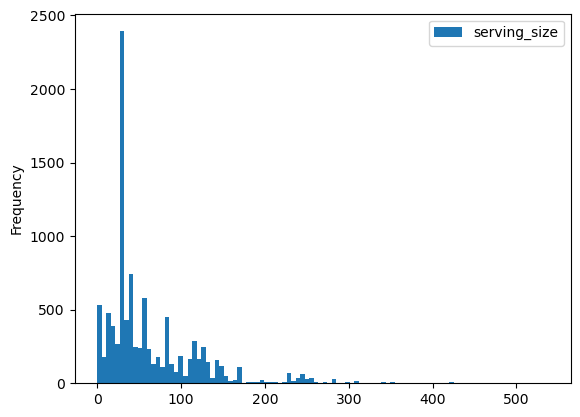

In [15]:
g_foods.sample(10000).plot(kind='hist', y='serving_size', bins=100)

<AxesSubplot:ylabel='Frequency'>

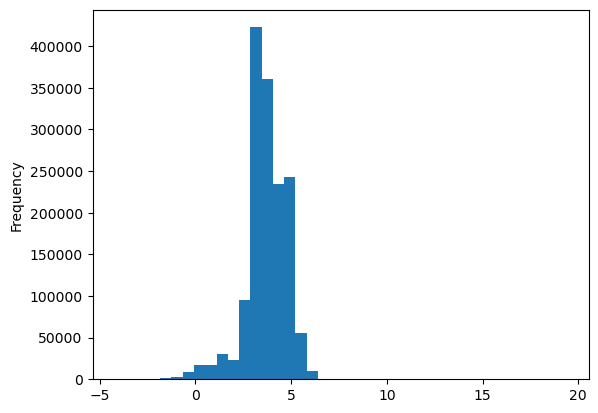

In [16]:
g_foods[g_foods.serving_size >= 0.001].serving_size.apply(np.log).plot(kind='hist', bins=40)

From many of the graphs, we can see that serving sizes above 600 are about rare. However, we can also possibly square root the graph to make it less receptive to outliers. A log transformation may not be possible as well, as some of the entries are 0, making log impossible. We will simply turn to the Box Plot method of removing outliers, where we consider anything above the 75% point (Q3) + 1.5 * (Q3 - Q1) to be an outlier, as well as anything below (Q1) - 1.5 * (Q3 - Q1).

<AxesSubplot:ylabel='Frequency'>

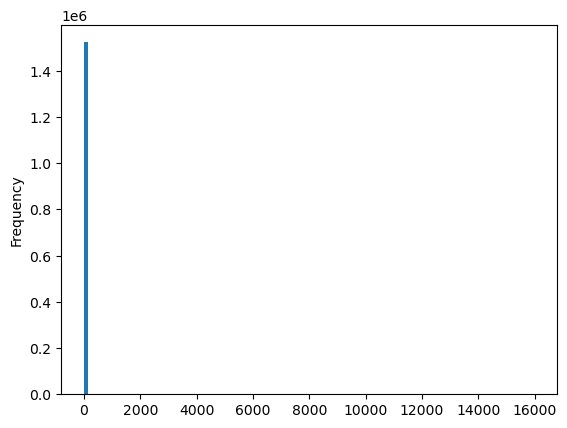

In [17]:
g_foods.serving_size.apply(np.sqrt).plot(kind='hist', bins=100)

In [18]:
g_food_iqr = g_stats.loc['75%'] - g_stats.loc['25%']
g_food_iqr

57.0

In [19]:
g_lower_outlier_bound = g_stats.loc['25%'] - 1.5 * g_food_iqr
g_lower_outlier_bound # Lower than zero, so we can ignore lower bounded outliers as there are none

-57.5

In [20]:
g_upper_bound = g_stats.loc['75%'] + 1.5 * g_food_iqr
g_upper_bound

170.5

In [21]:
g_foods_no_outlier = g_foods[g_foods.serving_size <= g_upper_bound]
print(g_foods.shape[0] - g_foods_no_outlier.shape[0], 'rows removed')

69578 rows removed


In [22]:
(g_foods.shape[0] - g_foods_no_outlier.shape[0]) / g_foods.shape[0] # Only 5% of the data was removed as outliers

0.04570433868689854

We repeat the process with grm foods:

In [23]:
grm_stats = grm_foods.serving_size.describe()
grm_stats

count    40597.000000
mean        64.826811
std         83.239828
min          0.060000
25%         28.000000
50%         36.000000
75%         88.000000
max       9979.000000
Name: serving_size, dtype: float64

One thing to point out is that the quantile statistics (25%, 50%, 75%) are similar between g and grm.

In [24]:
grm_iqr = grm_stats.loc['75%'] - grm_stats.loc['25%']
grm_iqr # This number exceeds the 25%, so we do not have to calculate lower bound

60.0

In [25]:
grm_upper_bound = grm_stats.loc['75%'] + grm_iqr * 1.5
grm_upper_bound # Also not too far off from gram's 75% 

178.0

In [26]:
grm_foods_no_outlier = grm_foods[grm_foods.serving_size <= grm_upper_bound]
(grm_foods.shape[0] - grm_foods_no_outlier.shape[0]) / grm_foods.shape[0] # Also removed about 5% of the data

0.05197428381407493

We will run permutation by both median and mean.

In [27]:
pd.concat([g_foods_no_outlier.sample(10000, replace=False), grm_foods_no_outlier])

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
79880,391549,"Post Consumer Brands, LLC",NaN,NaN,884912004666,"SUGAR, WHEAT, CORN SYRUP, HONEY, CARAMEL COLOR...",NaN,27.0,g,0.75 cup,Cereal,LI,NaN,2018-03-08,2019-04-01,United States,NaN,NaN,NaN,NaN
513851,1085625,Abbott Laboratories Inc,NaN,NaN,638102204905,INGREDIENTS: SOY PROTEIN NUGGETS (SOY PROTEIN ...,NaN,50.0,g,50 GRM,"Snack, Energy & Granola Bars",LI,NaN,2020-08-20,2020-09-29,United States,NaN,NaN,NaN,NaN
678989,1270980,The Good Earth Peanut Co.,GOOD EARTH PEANUT CO.,NaN,736660700188,"CASHEWS (PRODUCT OF BRAZIL), CANOLA OIL, SALT",NaN,30.0,g,NaN,"Popcorn, Peanuts, Seeds & Related Snacks",LI,NaN,2018-03-01,2021-02-26,United States,NaN,NaN,NaN,NaN
51269,362861,"Supervalu, Inc.",NaN,NaN,041303005033,BROWN RICE.,NaN,45.0,g,1/4 cup,Rice,LI,NaN,2018-12-07,2019-04-01,United States,NaN,NaN,NaN,NaN
1461647,2124140,Xlear Inc.,LITE AND SWEET,NaN,700596003101,"100% PURE ERYTHRITOL & XYLITOL - NO FILLERS, F...",NOT A SIGNIFICANT SOURCE OF OTHER NUTRIENTS.,4.0,g,NaN,"Granulated, Brown & Powdered Sugar",LI,NaN,2018-02-03,2021-10-28,United States,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845290,2554908,Tanjoe Enterprises Inc.,LIDIA'S,NaN,897712001049,"ITALIAN TOMATOES (CITRIC ACID), ARTICHOKES, CA...",NaN,125.0,GRM,1/2 cup,Prepared Pasta & Pizza Sauces,LI,25 oz/708 g,2023-03-27,2023-05-25,United States,NaN,NaN,NaN,NaN
1845291,2554909,Oregon Growers & Shippers LLC,OREGON GROWERS,NaN,898271000948,"BLACKBERRIES (MARIONBERRIES, BLACKBERRIES), CA...","Not a significant source of saturated fat, tra...",39.0,GRM,2 Tbsp,Syrups & Molasses,LI,8 fl oz/237 mL,2023-04-26,2023-05-25,United States,NaN,NaN,NaN,NaN
1845292,2554910,Mt. Garfield Winery Corp,LIFESTYLEFOODS,NaN,898425002682,ARCADIAN HARVEST LETTUCE (BLEND OF LEAF LETTUC...,NaN,163.0,GRM,NaN,"Pickles, Olives, Peppers & Relishes",LI,5.75 oz./163 g,2023-03-10,2023-05-25,United States,NaN,NaN,NaN,NaN
1845295,2554913,"Ittella International, Inc.",TATTOOED CHEF,NaN,899764001527,"CAULIFLOWER, CORN FLOUR, GRANA PADANO CHEESE (...",NaN,71.0,GRM,1 pc,Frozen Patties and Burgers,LI,10 oz/283 g,2023-03-23,2023-05-25,United States,NaN,NaN,NaN,NaN


## Gram permutation test

H0: The samples of grm and g come from the same distribution.

H1: The samples of grm and g come from different distributions.

alpha = .05

In [28]:
def test_stat(data, category, val_column, apply_func):
    return np.abs(data.groupby(category)[val_column].agg(apply_func).diff().iloc[-1])

def perm_test(apply_func, dist1, dist2, sample_size, category, val_column):
    """ Compute an (approximate) permutation test between two distributions using either median or mean. 
        Returns the p-value corresponding to the likelihood that the distributions are the same broader distribution. """
    sample_reps = 1000
    # Sample stat
    obs_stat = test_stat(pd.concat([dist1, dist2]), category, val_column, apply_func)
    
    samples = np.zeros(sample_reps)
    
    for i in range(sample_reps):
        # Create a dataset sampling both distributions equally
        sample = pd.concat([dist1.sample(sample_size, replace=False), dist2.sample(sample_size, replace=False)])

        # Shuffle around the label, and aggregate with apply function
        sample_stat = test_stat(sample, category, val_column, apply_func)
    
        # Add to samples
        samples[i] = sample_stat
        
    return obs_stat, np.mean(samples >= obs_stat)

In [29]:
perm_test('median', g_foods, grm_foods, 1000, 'serving_size_unit', 'serving_size')

(4.0, 0.628)

In [30]:
perm_test('mean', g_foods_no_outlier, grm_foods_no_outlier, 1000, 'serving_size_unit', 'serving_size')

(1.0513840208658678, 0.624)

In [31]:
perm_test('mean', g_foods, grm_foods, 1000, 'serving_size_unit', 'serving_size')

(335.72609011505784, 0.002)

We receive p-values towards about .5-.6 which exceeds our alpha level for the first two metrics. We see that while the first two give values above the alpha level, using the mean with all data points (including outliers) gave us a different p-value that would reject the null in favor of the alternative hypothesis. However, the one test that rejects the null hypothesis contains a metric that is very susceptible to outliers, so I choose not to fairly consider the third test. Overall, we fail to reject the null hypothesis, and will convert grm entries to g (grams).

In [32]:
branded_food['serving_size_unit'] = branded_food['serving_size_unit'].replace('GRM', 'g')

In [33]:
branded_food.serving_size_unit.value_counts()

g      1562947
ml      243399
MLT       8288
MG        7555
IU        3671
GM         346
MC          63
Name: serving_size_unit, dtype: int64

In [34]:
branded_food[branded_food.serving_size_unit == 'GM']

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1788278,2493495,Rite Aid Corporation,BIG WIN,NaN,011822399470,"FILTERED WATER, APPLE JUICE CONCENTRATE, ASCOR...","Not a significant source of saturated fat, tra...",240.0,GM,8 fl oz,"Fruit & Vegetable Juice, Nectars & Fruit Drinks",LI,16 fl oz/1 PT/473 mL,2023-02-13,2023-03-16,United States,NaN,NaN,NaN,NaN
1788293,2493510,Rite Aid Corporation,BIG WIN,NaN,011822446921,"BEEF, SUGAR, WATER, SEA SALT, GARLIC POWDER, Y...",NaN,28.0,GM,1 oz,Other Snacks,LI,6 oz/170 g,2023-02-13,2023-03-16,United States,NaN,NaN,NaN,NaN
1788601,2493818,Pepsi-Cola North America Inc.,DOLE,NaN,012000064524,"WATER, SUGAR, CITRIC ACID, LEMON JUICE CONCENT...",Not a significant source of other nutrients.,240.0,GM,8 fl oz,Soda,LI,2 L/2.1 Quart,2023-01-06,2023-03-16,United States,NaN,NaN,NaN,NaN
1788609,2493826,Pepsi-Cola North America Inc.,MTN DEW,NaN,012000100468,"CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CO...",Not a significant source of other nutrients.,360.0,GM,12 fl oz,Soda,LI,144 fl oz/4.26 L,2023-01-05,2023-03-16,United States,NaN,NaN,NaN,NaN
1789203,2494420,Pepsi-Cola North America Inc.,MTN DEW,NaN,012000809989,"CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CO...",Not a significant source of other nutrients.,360.0,GM,12 fl,Soda,LI,144 fl oz/4.26 L,2023-01-05,2023-03-16,United States,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829283,2538901,Watkins Incorporated,YELLOWSTONE,NaN,813724027976,"SEA SALT, DRIED GARLIC, BLACK PEPPER, TOASTED ...",NaN,1.2,GM,1/4 tsp,"Seasoning Mixes, Salts, Marinades & Tenderizers",LI,5.4 oz/155 g,2023-03-21,2023-04-27,United States,NaN,NaN,NaN,NaN
1829375,2538993,"The Hain Celestial Group, Inc.",SENSIBLE PORTIONS,GARDEN VEGGIE PUFFS,829515325077,"YELLOW CORN MEAL, CANOLA OIL AND/OR SAFFLOWER ...",NaN,28.0,GM,about 55 puffs,Other Snacks,LI,3.75 OZ/106 g,2023-03-03,2023-04-27,United States,NaN,NaN,NaN,NaN
1829376,2538994,"Texas Star Nut & Food Company, Inc.",NATURE'S EATS,NaN,832112003583,"CRANBERRIES (CRANBERRIES, SUGAR. SUNFLOWER OIL...",NaN,28.0,GM,1 oz,"Popcorn, Peanuts, Seeds & Related Snacks",LI,9 OZ/255 g,2023-03-15,2023-04-27,United States,NaN,NaN,NaN,NaN
1829524,2539142,Lil Michaels Munchies Inc.,OH! FRESH,NaN,850019038798,"WATER, LYCHEE JUICE, LYCHEE PULP, CANE SUGAR, ...","Not a significant source of saturated fat, tra...",250.0,GM,8.5 fl oz,"Fruit & Vegetable Juice, Nectars & Fruit Drinks",LI,500 mL/16.9 fl oz,2023-03-29,2023-04-27,United States,NaN,NaN,NaN,NaN


In [35]:
inspect_unit = lambda x: branded_food[branded_food.serving_size_unit == x]

In [45]:
mg_foods = inspect_unit('MG')
mg_foods[mg_foods.household_serving_fulltext.str.contains('g').fillna(False)]

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1789245,2494462,"Parks, LLC",PARKS FAMOUS FLAVOR,NaN,012400124118,"BEEF, WATER, BEEF HEARTS, NONFAT DRY MILK, SAL...","Not a significant source of Dietary Fiber,Vita...",85.000000,MG,1 Sausage,"Sausages, Hotdogs & Brats",LI,48 oz/3 lbs,2023-02-22,2023-03-16,United States,NaN,NaN,NaN,NaN
1789246,2494463,"Parks, LLC",PARKS FAMOUS FLAVOR,NaN,012400124415,"BEEF, WATER, BEEF HEARTS, NONFAT DRY MILK, SAL...","Not a significant source of Dietary Fiber,Vita...",85.000000,MG,1 Sausage,"Sausages, Hotdogs & Brats",LI,48 oz/3 lbs,2023-02-22,2023-03-16,United States,NaN,NaN,NaN,NaN
1789247,2494464,"Parks, LLC",PARKS FAMOUS FLAVOR,NaN,012400822120,"TURKEY, MECHANICALLY SEPARATED TURKEY, WATER, ...","Not a significant source of dietary fiber,Vita...",90.000000,MG,1 Sausage,"Sausages, Hotdogs & Brats",LI,48 oz/3 lbs,2023-02-22,2023-03-16,United States,NaN,NaN,NaN,NaN
1790174,2495391,"Rouse's Enterprises, Inc.",ROUSES MARKETS,NaN,015418016451,"CHICKEN BREAST, SEASONING (ENCAPSULATED VINEGA...",NaN,170.000000,MG,170 g,"Poultry, Chicken & Turkey",LI,24 oz/1.5 lbs/680 g,2023-01-28,2023-03-16,United States,NaN,NaN,NaN,NaN
1790252,2495469,"General Mills, Inc.",CINNAMON TOAST CRUNCH,NaN,016000168541,"WHOLE GRAIN OATS, CORN SYRUP, SUGAR, WHOLE WHE...",Not a significant source ofVitamin D.,70.000000,MG,70 g,"Snack, Energy & Granola Bars",LI,2 oz,2023-02-01,2023-03-16,United States,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829784,2539402,Growth Management Corporation dba Amigos/Kings...,AMIGOS,NaN,860007194351,SOFT PINTO BURRITO (FLOUR TORTILLA (ENRICHED W...,NaN,291.089996,MG,291.09 g,Prepared Wraps and Burittos,LI,20.5 oz/582 g,2023-03-29,2023-04-27,United States,NaN,NaN,NaN,NaN
1829785,2539403,Growth Management Corporation dba Amigos/Kings...,AMIGOS,NaN,860007194375,"FLOUR TORTILLA (ENRICHED WHEAT FLOUR, NIACIN, ...",NaN,113.400002,MG,113.4 g,Frozen Dinners & Entrees,LI,NaN,2023-03-30,2023-04-27,United States,NaN,NaN,NaN,NaN
1829793,2539411,"Glo's Gumbo, LLC",AMIGOS,NaN,860007644313,BACON BREAKFAST BURRITO (FLOUR TORTILLA (ENRIC...,NaN,231.919998,MG,231.92 g,Prepared Wraps and Burittos,LI,16.4 oz/464 g,2023-03-29,2023-04-27,United States,NaN,NaN,NaN,NaN
1829794,2539412,"Glo's Gumbo, LLC",AMIGOS,NaN,860007644351,CREAM CHEESE CHICKEN ENCHILADA (FLOUR TORTILLA...,NaN,501.239990,MG,1 serving,Other Deli,LI,17.7 oz/501 g,2023-03-29,2023-04-27,United States,NaN,NaN,NaN,NaN


We also see that the mg column may be possibly connected to grams, as shown by some samples where milligrams doesn't exactly make sense, and the household serving text also using "g" to denote some. However, these may also simply be typos, so it may not exactly be correct to convert the unit to grams. We will simply use a permutation test with the median to compare distributions this time so we don't have to filter out outliers. We use the same hypothesis setup still:

H0: The samples of g and mg come from the same distribution.

H1: The samples of g and mg come from different distributions.

alpha = .05

In [50]:
mg_stats = mg.serving_size.describe()
print(mg_stats)
mg_iqr = mg_stats['75%'] - mg_stats['25%']
mg_upper = g_stats['75%'] + 1.5 * mg_iqr
mg_foods_no_outlier = mg_foods[mg_foods.serving_size <= mg_upper]
mg_upper

count    7555.000000
mean       74.395588
std        80.860627
min         0.500000
25%        28.000000
50%        47.000000
75%        85.000000
max      2160.000000
Name: serving_size, dtype: float64


170.5

In [47]:
perm_test('median', g_foods, mg_foods, 5000, 'serving_size_unit', 'serving_size')

(7.0, 0.573)

In [48]:
mg_foods_no_outlier = mg_foods[mg_foods.serving_size <= mg_stats['75%'] + 1.5 * mg_iqr]

In [49]:
perm_test('mean', g_foods_no_outlier, mg_foods_no_outlier, 5000, 'serving_size_unit', 'serving_size')

(0.2769112391847628, 0.656)

We are inclined towards the belief that mg and g both come from the same distribution, so we shall also replace mg with g.

In [51]:
branded_food['serving_size_unit'] = branded_food.serving_size_unit.replace('MG', 'g')

In [52]:
branded_food.serving_size_unit.value_counts()

g      1570502
ml      243399
MLT       8288
IU        3671
GM         346
MC          63
Name: serving_size_unit, dtype: int64

In [55]:
gm_foods = inspect_unit('GM')
gm_foods.head()

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1788278,2493495,Rite Aid Corporation,BIG WIN,NaN,011822399470,"FILTERED WATER, APPLE JUICE CONCENTRATE, ASCOR...","Not a significant source of saturated fat, tra...",240.0,GM,8 fl oz,"Fruit & Vegetable Juice, Nectars & Fruit Drinks",LI,16 fl oz/1 PT/473 mL,2023-02-13,2023-03-16,United States,NaN,NaN,NaN,NaN
1788293,2493510,Rite Aid Corporation,BIG WIN,NaN,011822446921,"BEEF, SUGAR, WATER, SEA SALT, GARLIC POWDER, Y...",NaN,28.0,GM,1 oz,Other Snacks,LI,6 oz/170 g,2023-02-13,2023-03-16,United States,NaN,NaN,NaN,NaN
1788601,2493818,Pepsi-Cola North America Inc.,DOLE,NaN,012000064524,"WATER, SUGAR, CITRIC ACID, LEMON JUICE CONCENT...",Not a significant source of other nutrients.,240.0,GM,8 fl oz,Soda,LI,2 L/2.1 Quart,2023-01-06,2023-03-16,United States,NaN,NaN,NaN,NaN
1788609,2493826,Pepsi-Cola North America Inc.,MTN DEW,NaN,012000100468,"CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CO...",Not a significant source of other nutrients.,360.0,GM,12 fl oz,Soda,LI,144 fl oz/4.26 L,2023-01-05,2023-03-16,United States,NaN,NaN,NaN,NaN
1789203,2494420,Pepsi-Cola North America Inc.,MTN DEW,NaN,012000809989,"CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CO...",Not a significant source of other nutrients.,360.0,GM,12 fl,Soda,LI,144 fl oz/4.26 L,2023-01-05,2023-03-16,United States,NaN,NaN,NaN,NaN


In [56]:
gm_foods.shape[0]

346

Inspecting GM through the head function indicates that the unit may correspond to water/fluid based products, and most likely does not correspond to grams. We can also do a permutation test, and we expect it to fail. One thing to point out is the small sample size relative to previous permutation 

In [ ]:
perm_test('median', gm_foods, g_foods, 150, 'serving_size_unit', 'serving_size')